# Bayesian Linear Regression 
Computational bayes final project.  
Nathan Yee  
Uma Desai  

First example to gain understanding is taken from Cypress Frankenfeld.
http://allendowney.blogspot.com/2015/04/two-hour-marathon-by-2041-probably.html

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalNormalPdf
import thinkplot
import pandas as pd
import matplotlib.pyplot as plt

Load data from csv file

In [2]:
df = pd.read_csv('ageVsHeight.csv', skiprows=0, delimiter='\t')
df

,age,height
0,18,76.1
1,19,77.0
2,20,78.1
3,21,78.2
4,22,78.8
5,23,79.7
6,24,79.9
7,25,81.1
8,26,81.2
9,27,81.8


Create x and y vectors. x is the ages, y is the heights

In [3]:
ages = np.array(df['age'])
heights = np.array(df['height'])

Abstract least squares function using a function

In [4]:
def leastSquares(x, y):
    """
    leastSquares takes in two arrays of values. Then it returns the slope and intercept
    of the least squares of the two.
    
    Args:
        x (numpy array): numpy array of values.
        y (numpy array): numpy array of values.
        
    Returns:
        slope, intercept (tuple): returns a tuple of floats.
    """
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y)[0]
    return slope, intercept

Use the leastSquares function to get a slope and intercept. Then use the slope and intercept to calculate the size of our alpha and beta ranges

In [5]:
slope, intercept = leastSquares(ages, heights)
print(slope, intercept)
alpha_range = .03 * intercept
beta_range = .05 * slope

0.634965034965 64.9283216783


Visualize the slope and intercept on the same plot as the data so make sure it is working correctly

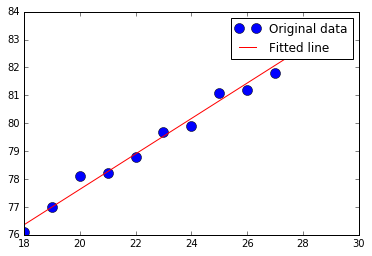

In [6]:
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
plt.legend()
plt.show()

Make range of alphas (intercepts), betas (slopes), and sigmas (errors)

In [7]:
alphas = np.linspace(intercept - alpha_range, intercept + alpha_range, 20)
betas = np.linspace(slope - beta_range, slope + beta_range, 20)
sigmas = np.linspace(2, 4, 15)

# alphas = np.linspace(intercept * (1 - alpha_range),
#                      intercept * (1 + alpha_range),
#                      5)
# betas = np.linspace(slope * (1 - beta_range),
#                     slope * (1 + beta_range),
#                     5)
# sigmas = np.linspace(.1, .2, 5)

# alphas = np.linspace(65, 75, 20)
# betas = np.linspace(.4, .55, 20)
# sigmas = np.linspace(2, 3.5, 10)

Turn those alphas, betas, and sigmas into our hypotheses

In [8]:
hypos = ((alpha, beta, sigma) for alpha in alphas 
         for beta in betas for sigma in sigmas)

Make data

In [9]:
data = [(age, height) for age in ages for height in heights]

Next make age class where likelihood is calculated based on error from data

In [10]:
class leastSquaresHypos(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        Likelihood calculates the probability of a particular line (hypo)
        based on data (ages Vs height) of our original dataset. This is
        done with a normal pmf as each hypo also contains a sigma.
        
        Args:
            data (tuple): tuple that contains ages (float), heights (float)
            hypo (tuple): intercept (float), slope (float), sigma (float)
            
        Returns:
            P(data|hypo)
        """
        intercept, slope, sigma = hypo
        total_likelihood = 1
        for age, measured_height in data:
            hypothesized_height = slope * age + intercept
            error = measured_height - hypothesized_height
            total_likelihood *= EvalNormalPdf(error, mu=0, sigma=sigma)
        return total_likelihood
        

In [11]:
LeastSquaresHypos = leastSquaresHypos(hypos)

In [12]:
for item in data:
    LeastSquaresHypos.Update([item])

In [13]:
LeastSquaresHypos[LeastSquaresHypos.MaximumLikelihood()]

0.030830865048858944

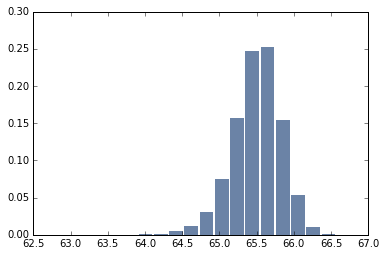

In [14]:
marginal_intercepts = LeastSquaresHypos.Marginal(0)
thinkplot.hist(marginal_intercepts)

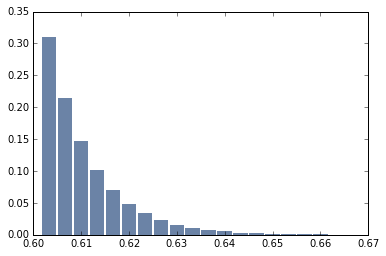

In [15]:
marginal_slopes = LeastSquaresHypos.Marginal(1)
thinkplot.hist(marginal_slopes)

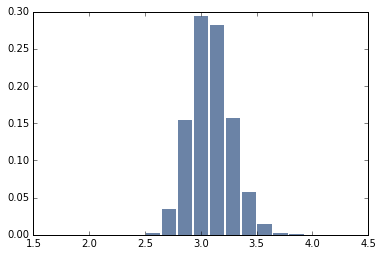

In [16]:
marginal_sigmas = LeastSquaresHypos.Marginal(2)
thinkplot.hist(marginal_sigmas)

In [17]:
def getHeights(hypo_samples, random_months):
    """
    getHeights takes in random hypos and random months and returns the coorisponding
    random height
    
    Args:
        hypo_samples
    """
    random_heights = np.zeros(len(random_months))
    for i in range(len(random_heights)):
        intercept = hypo_samples[i][0]
        slope = hypo_samples[i][1]
        sigma = hypo_samples[i][2]
        month = random_months[i]
        random_heights[i] = np.random.normal((slope * month + intercept), sigma, 1)
    return random_heights

def getRandomData(start_month, end_month, n, LeastSquaresHypos):
    """
    n - number of samples
    """
    random_hypos = LeastSquaresHypos.Sample(n)
    random_months = np.random.uniform(start_month, end_month, n)
    random_heights = getHeights(random_hypos, random_months)
    return random_months, random_heights

Get random samples of pairs of months and heights. Here we want at least 10000 items to get very smooth sampling

In [18]:
num_samples = 10000
random_months, random_heights = getRandomData(18, 40, num_samples, LeastSquaresHypos)

Next, we want to get the intensity of the data at locations. We do adding the randomly sampled values to buckets. This gives us intensity values for a grid of pixels in our sample range.

In [19]:
num_buckets = 70 # num_buckets^2 is actual number

# create horizontal and vertical linearly spaced ranges as buckets.
hori_range, hori_step = np.linspace(18, 40 , num_buckets, retstep=True)
vert_range, vert_step = np.linspace(65, 100, num_buckets, retstep=True)

hori_step = hori_step / 2
vert_step = vert_step / 2

# store each bucket as a tuple in a the buckets dictionary.
buckets = dict()
keys = [(hori, vert) for hori in hori_range for vert in vert_range]

# set each bucket as empty
for key in keys:
    buckets[key] = 0
    
# loop through the randomly sampled data
for month, height in zip(random_months, random_heights):
    # check each bucket and see if randomly sampled data 
    for key in buckets:
        if month > key[0] - hori_step and month < key[0] + hori_step:
            if height > key[1] - vert_step and height < key[1] + vert_step:
                buckets[key] += 1
                break # can only fit in a single bucket

In [20]:
pcolor_months = []
pcolor_heights = []
pcolor_intensities = []
for key in buckets:
    pcolor_months.append(key[0])
    pcolor_heights.append(key[1])
    pcolor_intensities.append(buckets[key])   
    
print(len(pcolor_months), len(pcolor_heights), len(pcolor_intensities))

4900 4900 4900


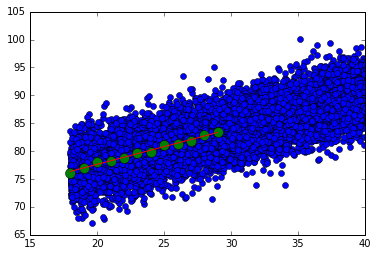

In [21]:
plt.plot(random_months, random_heights, 'o', label='Random Sampling')
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
# plt.legend()
plt.show()

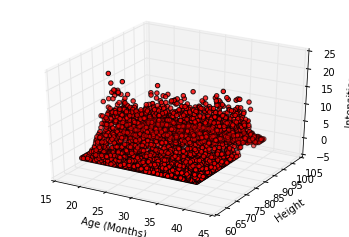

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = pcolor_months
y = pcolor_heights
z = pcolor_intensities



ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Age (Months)')
ax.set_ylabel('Height')
ax.set_zlabel('Intensities')

plt.show()

Since density plotting is much easier in Mathematica, we are going to export all our data to csv files and plot them in Mathematica

In [23]:
def append_to_file(path, data):
    """
    append_to_file appends a line of data to specified file.  Then adds new line
    
    Args:
        path (string): the file path
    
    Return:
        VOID
    """
    with open(path, 'a') as file:
        file.write(data + '\n')
        
def delete_file_contents(path):
    """
    delete_file_contents deletes the contents of a file
    
    Args:
        path: (string): the file path
        
    Return:
        VOID
    """
    with open(path, 'w'):
        pass

def intensityCSV(x, y, z):
    file_name = 'intensityData.csv'
    delete_file_contents(file_name)

    for xi, yi, zi in zip(x, y, z):
        append_to_file(file_name, "{}, {}, {}".format(xi, yi, zi))
        
def monthHeightCSV(ages, heights):
    file_name = 'monthsHeights.csv'
    delete_file_contents(file_name)
    
    for month, height in zip(ages, heights):
        append_to_file(file_name, "{}, {}".format(month, height))
        
def fittedLineCSV(ages, slope, intercept):
    file_name = 'fittedLineCSV.csv'
    delete_file_contents(file_name)
    for age in ages:
        append_to_file(file_name, "{}, {}".format(age, slope*age + intercept))
        
def makeCSVData(pcolor_months, pcolor_heights, pcolor_intensities, ages, heights, slope, intercept):
    intensityCSV(pcolor_months, pcolor_heights, pcolor_intensities)
    monthHeightCSV(ages, heights)
    fittedLineCSV(ages, slope, intercept)

In [24]:
makeCSVData(pcolor_months, pcolor_heights, pcolor_intensities, ages, heights, slope, intercept)